<a href="https://colab.research.google.com/github/soroushmirzaei/computer-vision-projects/blob/main/rock-paper-scissors-classification/rock-paper-scissors-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirements libraries
import os
import zipfile

#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [ ]:
#download dataset
!curl -o RockPaperScissors.zip "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip"
!curl -o RockPaperScissorsValidation.zip "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip"
!curl -o RockPaperScissorsTest.zip "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  191M  100  191M    0     0  61.5M      0  0:00:03  0:00:03 --:--:-- 61.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6468k  100 6468k    0     0  9668k      0 --:--:-- --:--:-- --:--:-- 9654k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.1M  100 28.1M    0     0  35.0M      0 --:--:-- --:--:-- --:--:-- 35.0M


In [ ]:
#unzip files
def unzip(src_path):
    file = zipfile.ZipFile(src_path)
    file.extractall(src_path.split('/')[-1].split('.')[-2])
    file.close()

unzip('/content/RockPaperScissors.zip')
unzip('/content/RockPaperScissorsValidation.zip')
unzip('/content/RockPaperScissorsTest.zip')


In [ ]:
#define files with size zero and remove them
for label in os.scandir('/content/RockPaperScissors/rps'):
    for image in os.scandir(label.path):
        if os.path.getsize(image.path) == 0:
            os.remove(image.path)

for label in os.scandir('/content/RockPaperScissorsTest/rps-test-set'):
    for image in os.scandir(label.path):
        if os.path.getsize(image.path) == 0:
            os.remove(image.path)


In [ ]:
#define image data generator and load trainig and validation set
Height = 150
Width = 150

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, horizontal_flip = True,
                                                         height_shift_range = 0.3, width_shift_range = 0.3,
                                                         zoom_range = 0.1, fill_mode = 'nearest')
train_data = train_gen.flow_from_directory('/content/RockPaperScissors/rps',
                                           target_size = (Height, Width), batch_size = 32,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

valid_data = valid_gen.flow_from_directory('/content/RockPaperScissorsTest/rps-test-set',
                                           target_size = (Height, Width), batch_size = 32,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0)


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [ ]:
#load pretrained model
pretrained_model_resnet = keras.applications.ResNet50V2(include_top = False, input_shape = (Height, Width, 3))
pretrained_model_xception = keras.applications.Xception(include_top = False, input_shape = (Height, Width, 3))

#define layers trainable false
for layer in pretrained_model_resnet.layers:
    layer.trainable = False

for layer in pretrained_model_xception.layers:
    layer.trainable = False
    

In [ ]:
#create model function
def create_model(inp_shape, dense_layers_num, dense_drop_ratio, dense_units,
                 out_drop_ratio, out_units, out_activation, compile_optimizer, compile_loss , compile_metric,
                 #model layers configuration
                 dense_activation = 'relu', dense_head = True, batch_norm_dense = True, batch_norm_out = True,
                 drop_dense = True, drop_out = True):

    input = keras.Input(shape = inp_shape)

    #pretrained models
    out_resnet = pretrained_model_resnet(input)
    out_xception = pretrained_model_xception(input)

    #concatenate pretrained models output
    out_conc = keras.layers.Concatenate()([out_resnet, out_xception])    

    out = keras.layers.Flatten()(out_conc)

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                     kernel_initializer = keras.initializers.HeNormal())(out)
            if drop_dense:
                out = keras.layers.Dropout(dense_drop_ratio[i])(out)

    #define output layers
    if batch_norm_out:
        out = keras.layers.Dropout(out_drop_ratio)(out)
    if drop_out:
        out = keras.layers.BatchNormalization()(out)
    output = keras.layers.Dense(units = out_units, activation = out_activation)(out)

    model = keras.models.Model(input, output)

    #define model compile
    model.compile(optimizer = compile_optimizer,
                  loss = compile_loss,
                  metrics = compile_metric)

    return model


In [ ]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        self.model.save('/content/rock-paper-scissors-model.h5')
        

In [ ]:
#create model
model = create_model(inp_shape = (Height,Height,3), dense_layers_num = 2, dense_drop_ratio = [0.2, 0.2] , dense_units = [64, 64],
                     out_drop_ratio = 0.3, out_units = 3,
                     out_activation = 'softmax', compile_optimizer = 'adam', compile_loss ='sparse_categorical_crossentropy' ,
                     compile_metric = ['accuracy'], dense_activation = 'relu', dense_head = True,
                     batch_norm_dense = True, batch_norm_out = True, drop_dense = True, drop_out = True)


In [ ]:
#fit model for training
model.fit(train_data, validation_data = valid_data, epochs = 100,
          callbacks = [keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True, monitor = 'val_loss'),
                       keras.callbacks.CSVLogger('Log.csv'), callback()])


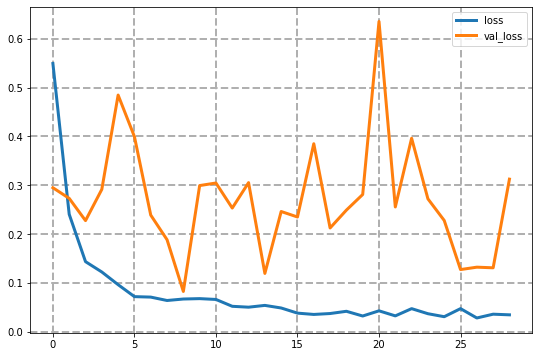

In [ ]:
#plot training model loss
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


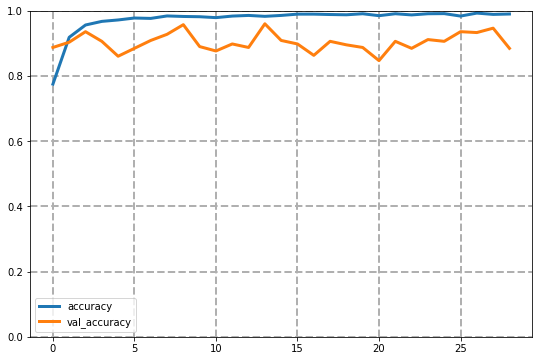

In [ ]:
#plot training model accuracy
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#model evaluation
train_set_eval = model.evaluate(train_data, verbose = 0)
valid_set_eval = model.evaluate(valid_data, verbose = 0)

print(f'Training Set Evaluation:\n\tLoss: {round(train_set_eval[0],4)}\tAccuracy: {100*round(train_set_eval[1],4)}%')
print(f'Validation Set Evaluation:\n\tLoss: {round(valid_set_eval[0],4)}\tAccuracy: {100*round(valid_set_eval[1],4)}%')


Training Set Evaluation:
	Loss: 0.0141	Accuracy: 99.56%
Validation Set Evaluation:
	Loss: 0.0824	Accuracy: 95.7%


In [ ]:
#make list of all images in directory
ls = []
for image in os.scandir('/content/RockPaperScissorsValidation'):
    ls.append(image.path)


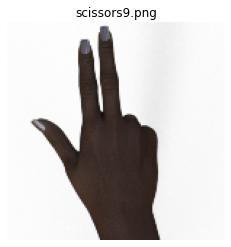

In [ ]:
#select randomly an image and draw it
img = np.random.choice(ls)
image = img
img = keras.preprocessing.image.load_img(img, target_size = (Height, Width), color_mode = 'rgb')
img = keras.preprocessing.image.img_to_array(img)
img = img/255

plt.axis('off')
plt.imshow(img)
plt.title(image.split('/')[-1])
plt.show()


In [ ]:
#predict the image
img = np.expand_dims(img, 0)
pd.DataFrame(model.predict(img), columns = train_data.class_indices)


,paper,rock,scissors
0,0.0002,0.000071,0.99973


In [ ]:
#save model
model.save('/content/rock-paper-scissors-classification-model.h5')
